In [1]:
import os
import sys
sys.path.insert(0, "..")
import inspect
import torch
import torch.optim as optim

import wandb
from safetensors import safe_open
from tqdm import tqdm

import matplotlib.pyplot as plt

from notebook_utils import *

from models import *
from my_datasets import *
from experiments import *

In [2]:
torch.manual_seed(1234)
ns_model, dataset = quickload_next_state_model_and_dataset()

checking /home/antonxue/foo/tf_logic/notebooks/artifacts/model-SynNS_gpt2_d1024_L2_H4__nv128_nr16-64_ns8-32_ap0.30-0.50_bp0.20-0.30_sp0.50-0.50_ntr32768_ntt8192:v0, True


In [3]:
atk_model = ForceOutputAttackerModel(
    input_dim = ns_model.input_dim,
    target_dim = ns_model.num_labels,
    num_outputs = 3)

In [4]:
batch_size = 16
v_tgt = torch.randint(0,2, (batch_size, dataset.num_vars))
u = torch.stack([dataset[i]["tokens"] for i in range(batch_size)])

v_tgt.shape, u.shape
u_atk = atk_model(u, v_tgt)
v_tgt.shape, u.shape, u_atk.shape

(torch.Size([16, 128]), torch.Size([16, 96, 257]), torch.Size([16, 3, 257]))

In [5]:
# Setup the optimization problem
ns_model.eval().cuda()
for p in ns_model.parameters():
    p.requires_grad = False

atk_model.train().cuda()
optimizer = optim.Adam(atk_model.parameters())

In [6]:
u = u.cuda()
v_tgt = v_tgt.cuda()

v_loss_fn = nn.BCEWithLogitsLoss(reduction="sum")

In [7]:
pbar = tqdm(range(2000))
init_loss, init_unorm_loss, init_vpred_loss = 0.0, 0.0, 0.0
for i, t in enumerate(pbar):
    u_atk = atk_model(u, v_tgt)
    v_pred = ns_model(torch.cat([u, u_atk], dim=1)).logits

    unorm_loss = 1e-2 * torch.norm(u_atk, p=2)**2
    vpred_loss = v_loss_fn(v_pred, v_tgt.float())
    loss = unorm_loss + vpred_loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if i == 0:
        init_loss = loss.cpu().detach().item()
        init_unorm_loss = unorm_loss.cpu().detach().item()
        init_vpred_loss = vpred_loss.cpu().detach().item()
        
    desc = f"init {init_loss:.3f} ({init_unorm_loss:.3f}, {init_vpred_loss:.3f})"
    desc += f", loss {loss:.3f} ({unorm_loss:.3f}, {vpred_loss:.3f})"
    pbar.set_description(desc)

init 4740.908 (1131.574, 3609.333), loss 35.127 (4.737, 30.391): 100%|██████████| 2000/2000 [02:43<00:00, 12.23it/s]    


In [8]:
v_try_soft = ns_model(torch.cat([u, u_atk], dim=1)).logits.sigmoid().cpu().detach()
v_try_hard = (v_try_soft > 0.5).long()
v_tgt = v_tgt.cpu().detach()

In [9]:
diff_soft = (v_try_soft - v_tgt).abs()
diff_hard = (v_try_hard - v_tgt).abs()
diff_soft.sum(), diff_hard.sum()

(tensor(30.1031), tensor(0))

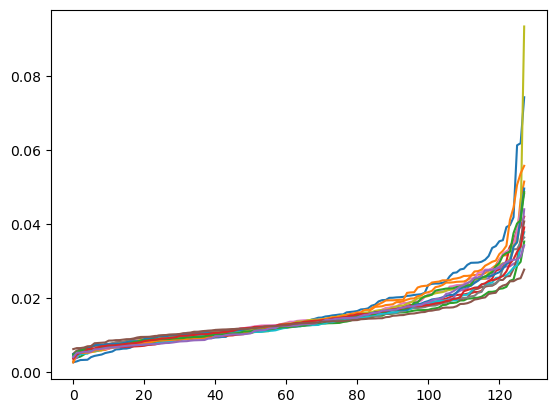

In [10]:
plt.clf()
for i, ds in enumerate(diff_soft):
    plt.plot(ds.sort().values.numpy())